In [1]:
import pandas as pd
import numpy as np

## Task

### Resources

In [2]:
# Fairness metrics
def CohenD(yobs, ypred, gmaj, gmin):
    ### Cohen-D
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    
    STD_maj = np.sqrt(SR_maj * (1.0 - SR_maj))
    STD_min = np.sqrt(SR_min * (1.0 - SR_min))
    POOL_STD = STD_maj * ( sum(gmaj==1)/(sum(gmin==1) + sum(gmaj==1)) ) + STD_min * ( sum(gmin==1)/(sum(gmin==1) + sum(gmaj==1)) )
    
    return StatParity(yobs, ypred, gmaj, gmin)/POOL_STD

def DispImpact(yobs, ypred, gmaj, gmin):
    ### Disparate Impact (a.k.a. Adverse Impact Ratio)
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min/SR_maj

def StatParity(yobs, ypred, gmaj, gmin):
    ### Statistical Parity Difference
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    return SR_min - SR_maj

def TwoSDRule(yobs, ypred, gmaj, gmin):
    ### 2-SD Rule
    SR_min = ypred[gmin==1].mean() # success rate minority
    SR_maj = ypred[gmaj==1].mean() # success rate majority
    SR_T = ypred.mean() # success rate total
    P_min = (gmin==1).mean() # minority proportion
    N = len(ypred)
    return (SR_min - SR_maj)/np.sqrt( (SR_T * (1.0 - SR_T))/(N * P_min * (1 - P_min)) )

def EqualOppDiff(yobs, ypred, gmaj, gmin):
    ### Equal Opportunity Difference
    TPR_maj = sum( (yobs[gmaj==1]==1) * (ypred[gmaj==1]==1) )/sum(yobs[gmaj==1]==1)
    TPR_min = sum( (yobs[gmin==1]==1) * (ypred[gmin==1]==1) )/sum(yobs[gmin==1]==1)
    return TPR_min - TPR_maj

def AvgOddsDiff(yobs, ypred, gmaj, gmin):
    ### Average Odds Difference
    return (EqualOppDiff(yobs==0, ypred==0, gmaj, gmin) + EqualOppDiff(yobs, ypred, gmaj, gmin))/2.0


def compute_model_metrics(yobs, model, Xobs, gmaj=None, gmin=None):
    # metrics
    from sklearn import metrics
    perf_metrics = {"Accuracy": metrics.accuracy_score, 
                    "Precision": metrics.precision_score, 
                    "Recall": metrics.recall_score,
                    "AUC": metrics.roc_auc_score, 
                    "F1-Score": metrics.f1_score, 
                    "Brier": metrics.brier_score_loss
                   }
    # fairness metrics
    fair_metrics = {"Cohen-D": CohenD,
                    "2-SD Rule": TwoSDRule,
                    "StatParity": StatParity,
                    "EqualOppDiff": EqualOppDiff,
                    "DispImpact": DispImpact,
                    "AvgOddsDiff": AvgOddsDiff
                   }
    
    # get predictions -- where you would start, after loading the data and model
    ypred_prob = model.predict_proba(Xobs).ravel()[1::2] # get probabilities
    ypred_class = model.predict(Xobs)
    
    # compute performance metrics
    metrics = []
    for pf in perf_metrics.keys():
        if pf in ["AUC", "Brier"]:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_prob)]]
        else:
            metrics += [[pf, perf_metrics[pf](yobs, ypred_class)]]
            
    if (gmaj is not None) and (gmin is not None):
        for ff in fair_metrics.keys():
            metrics += [[ff, fair_metrics[ff](yobs, ypred_class, gmaj, gmin)]]
    
    return pd.DataFrame(metrics, columns=["Metric", "Value"])

### Dataset

In [3]:
# get dataset
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort3/master/german_credit.csv")
sex_ps = df["personal_status_sex"].str.split(":", n = 1, expand = True)
sex_ps.columns = ["gender", "personal_status"]
df.drop("personal_status_sex", axis=1, inplace=True)
df = pd.concat([df, sex_ps], axis=1)

# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'gender', 'personal_status',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']

# target variable
output_variable = ["default"]

### Pre-processing
# Mapping categorical variables to one-hot encoding
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# consolidating a final dataset
df_final = pd.concat([df[int_variables], df_cat, df_age, df[output_variable]], axis=1)
X = pd.concat([df[int_variables], df_cat, df_age], axis=1)
y = df[output_variable].copy()

### Modelling

In [6]:
# set metrics
# performance metrics
gmaj = df_final[['gender_male ']]
gmin = df_final[['gender_female ']]

# train model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
#rf = RandomForestClassifier(n_estimators=10, random_state=10, class_weight="balanced")
#rf = MLPClassifier(random_state=10, solver="lbfgs")
rf = LogisticRegression(C=0.0025, random_state=10, class_weight="balanced", solver="lbfgs")
rf = rf.fit(X, y.values.ravel())

# compute metrics
compute_model_metrics(y.values.ravel(), rf, X, gmaj.values.ravel(), gmin.values.ravel())

,Metric,Value
0,Accuracy,0.677000
1,Precision,0.472289
2,Recall,0.653333
3,AUC,0.733633
4,F1-Score,0.548252
5,Brier,0.215226
6,Cohen-D,0.290594
7,2-SD Rule,4.211641
8,StatParity,0.141889
9,EqualOppDiff,0.184255


## Evaluation Component

### Bootstrap, Permutation and Noising Magic

### Bootstrap

In [7]:
def bootstrap_magic(X, y, model, n_samples, refit=False, gmaj=None, gmin=None):
    # pre-allocation
    np.random.seed(10)
    df_instances = pd.DataFrame(index=X.index, columns=["sample_" + str(x) for x in range(n_samples)])
    
    for s in range(n_samples):        
        # simple bootstrap
        idx = np.random.choice(X.index, X.shape[0])
        
        # left-out indices
        odx = np.array(list(set(X.index) - set(idx)))
        
        # train the model before evaluation?
        if refit: 
            model.fit(X.loc[idx], y.loc[idx].values.ravel())
        
        # get predictions to left-out
        #df_instances.loc[odx, "sample_" + str(s)] = model.predict(X.loc[odx])
        df_instances["sample_" + str(s)].loc[odx] = model.predict_proba(X.loc[odx]).ravel()[1::2]
        
        # evaluate model
        if (gmaj is not None) and (gmin is not None):
            df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx], 
                                               gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
        else:
            df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx])
            
        df_metrics["Sample"] = s
        if s is 0:
            df_all_metrics = df_metrics.copy()
        else:
            df_all_metrics = pd.concat([df_all_metrics, df_metrics.copy()], axis=0, ignore_index=True)

    return {"instances": df_instances, "metrics": df_all_metrics}

In [13]:
c = bootstrap_magic(X=X, y=y, model=rf, n_samples=100, refit=True, gmaj=gmaj, gmin=gmin)

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the nu

In [39]:
c["instances"].mean(axis=1).head(), y.head()

(0    0.189986
 1    0.762169
 2    0.276358
 3    0.666406
 4    0.491180
 dtype: float64,    default
 0        0
 1        1
 2        0
 3        0
 4        1)

#### Instance importance - performance

In [14]:
(y.values.ravel() - c["instances"].mean(axis=1)).abs().sort_values(ascending=False).head(10)

616    0.821759
637    0.819602
134    0.797373
272    0.786848
285    0.770957
685    0.768356
130    0.766031
255    0.765603
137    0.763409
286    0.761691
dtype: float64

In [40]:
X.loc[(y.values.ravel() - c["instances"].mean(axis=1)).abs().sort_values(ascending=False).head(10).index] # do a lime for them

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
616,1,2,60,1,2,27,9157,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
637,2,4,60,1,2,21,15653,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
134,1,4,60,1,2,21,10144,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
272,1,4,48,1,4,36,12169,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
285,1,1,47,1,1,35,10722,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
685,1,4,60,2,4,34,6527,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
130,1,2,48,1,1,24,8487,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
255,1,1,60,1,1,27,7418,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
137,1,3,12,1,4,66,766,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
286,1,3,48,2,4,26,4788,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


#### instance importance - fairness - minority group

In [16]:
(y.values.ravel() - c["instances"].mean(axis=1)).abs()[gmin.values.ravel()==1].sort_values(ascending=False).head(10)

134    0.797373
285    0.770957
130    0.766031
945    0.751991
186    0.721157
667    0.708941
141    0.694622
735    0.693659
70     0.652206
73     0.651332
dtype: float64

In [41]:
X.loc[(y.values.ravel() - c["instances"].mean(axis=1)).abs()[
    gmin.values.ravel()==1].sort_values(ascending=False).head(10).index] # do a lime for them

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,age,credit_amount,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,...,telephone_none,"telephone_yes, registered under the customers name",other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior
134,1,4,60,1,2,21,10144,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
285,1,1,47,1,1,35,10722,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
130,1,2,48,1,1,24,8487,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
945,2,1,48,1,1,30,8358,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
186,1,4,9,2,2,74,5129,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
667,1,1,48,1,1,27,3609,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
141,1,1,36,1,4,30,4795,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
735,1,2,36,1,3,29,3990,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
70,1,2,36,1,1,30,8133,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
73,2,1,42,1,2,41,5954,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


#### Avg case metrics + uncertainty

In [17]:
c["metrics"].pivot_table(values="Value", index="Metric", aggfunc=["mean", "median", "std", "mad"])

,mean,median,std,mad
,Value,Value,Value,Value
Metric,,,,
2-SD Rule,2.605503,2.607494,0.996064,0.783895
AUC,0.714922,0.714911,0.028628,0.023953
Accuracy,0.659724,0.658554,0.023292,0.018492
AvgOddsDiff,0.050447,0.053776,0.049911,0.039995
Brier,0.218847,0.218849,0.004979,0.004154
Cohen-D,0.298641,0.294556,0.117482,0.092617
DispImpact,1.400415,1.393361,0.173830,0.136454
EqualOppDiff,0.190220,0.196084,0.085724,0.069199


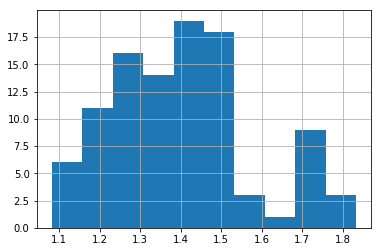

In [27]:
%matplotlib inline
c["metrics"].pivot_table(index="Sample", columns="Metric")["Value"]["DispImpact"].hist()

#### Worst/Best-case metrics

In [29]:
def q05(x):
    return np.quantile(x, q=.05)

def q95(x):
    return np.quantile(x, q=.95)

c["metrics"].pivot_table(values="Value", index="Metric", aggfunc=[q05, "median", "mean", q95])

,q05,median,mean,q95
,Value,Value,Value,Value
Metric,,,,
2-SD Rule,1.074700,2.607494,2.605503,4.524200
AUC,0.674611,0.714911,0.714922,0.756711
Accuracy,0.617957,0.658554,0.659724,0.695082
AvgOddsDiff,-0.034033,0.053776,0.050447,0.122865
Brier,0.211947,0.218849,0.218847,0.226852
Cohen-D,0.121826,0.294556,0.298641,0.528460
DispImpact,1.155727,1.393361,1.400415,1.733399
EqualOppDiff,0.039339,0.196084,0.190220,0.326601


### Permutation

In [43]:
def permutation_magic(X, y, model, n_repeats, refit=False, gmaj=None, gmin=None):
    # pre-allocation
    np.random.seed(10)
    
    for r in range(n_repeats):        
        # simple bootstrap
        idx = np.random.choice(X.index, X.shape[0])
        
        # left-out indices
        odx = np.array(list(set(X.index) - set(idx)))
        
        # train the model before evaluation?
        if refit: 
            model.fit(X.loc[idx], y.loc[idx].values.ravel())
        
        # baseline performance
        if (gmaj is not None) and (gmin is not None):
            df_baseline_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx], 
                                                        gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
        else:
            df_baseline_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X.loc[odx])
        
        # random permutation
        X_permuted = X.copy()
        X_features = X.columns
        shuffling_idx = np.arange(X.shape[0])
        for (j, col_idx) in enumerate(X_features):
            # shuffle
            np.random.shuffle(shuffling_idx)       
            if hasattr(X_permuted, "iloc"):
                col = X_permuted.iloc[shuffling_idx, j]
                col.index = X_permuted.index
                X_permuted.iloc[:, j] = col
            else:
                X_permuted[:, j] = X_permuted[shuffling_idx, col_idx]
            
            # compute performance
            if (gmaj is not None) and (gmin is not None):
                df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X_permuted.loc[odx], 
                                                   gmaj.loc[odx].values.ravel(), gmin.loc[odx].values.ravel())
            else:
                df_metrics = compute_model_metrics(y.loc[odx].values.ravel(), model, X_permuted.loc[odx])
        
            # store results
            df_metrics["Value"] = (df_baseline_metrics["Value"] - df_metrics["Value"])
            df_metrics["Variable"] = col_idx
            if j is 0:
                df_var_metrics = df_metrics.copy()
            else:
                df_var_metrics = pd.concat([df_var_metrics, df_metrics.copy()], axis=0, ignore_index=True)
        
        # store overall results
        df_var_metrics["Repeat"] = r
        if r is 0:
            df_all_metrics = df_var_metrics.copy()
        else:
            df_all_metrics = pd.concat([df_all_metrics, df_var_metrics.copy()], axis=0, ignore_index=True)
        
    return {"metrics": df_all_metrics}

#### Feature importance

In [44]:
c = permutation_magic(X=X, y=y, model=rf, n_repeats=10, refit=True, gmaj=gmaj, gmin=gmin)

C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Koshiyama\Anaconda3-64bit\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [45]:
d=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc="mean")

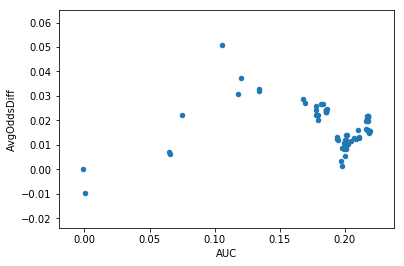

In [49]:
%matplotlib inline
d.plot(x="AUC", y="AvgOddsDiff", kind="scatter")

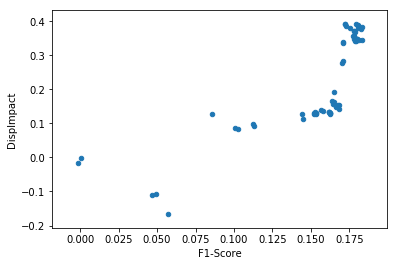

In [50]:
%matplotlib inline
d.plot(x="F1-Score", y="DispImpact", kind="scatter")

In [53]:
b=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc=["mean", "std"])
b["mean"]["AUC"].sort_values().tail(10)

Variable
other_debtors_co-applicant                                           0.217408
other_debtors_none                                                   0.217464
other_debtors_guarantor                                              0.217526
foreign_worker_yes                                                   0.217782
foreign_worker_no                                                    0.217801
job_unskilled - resident                                             0.217819
job_unemployed/ unskilled - non-resident                             0.218215
job_skilled employee / official                                      0.218284
job_management/ self-employed/ highly qualified employee/ officer    0.218851
housing_rent                                                         0.218967
Name: AUC, dtype: float64

In [54]:
b=c["metrics"].pivot_table(index="Variable", columns="Metric", values="Value", aggfunc=["mean", "std"])
b["mean"]["DispImpact"].sort_values().tail(10)

Variable
job_management/ self-employed/ highly qualified employee/ officer            0.376675
housing_own                                                                  0.379015
property_real estate                                                         0.380863
housing_rent                                                                 0.383205
personal_status_ single                                                      0.385860
job_unemployed/ unskilled - non-resident                                     0.386595
job_skilled employee / official                                              0.388791
job_unskilled - resident                                                     0.392038
property_if not A121 : building society savings agreement/ life insurance    0.392926
property_if not A121/A122 : car or other, not in attribute 6                 0.392991
Name: DispImpact, dtype: float64

### Noising

In [ ]:
# binary noise for one-hot encoded
# gaussian noise for everyone else

### Adversarial Attacks stuff

## Fix Component